In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter, MultipleLocator
import seaborn as sns
import json
import datetime as dt
import numpy as np
from scipy.interpolate import make_interp_spline, BSpline

import re

from consts_and_funcs import *

# Record
let's look at my records, divided into time categories

the data was fetched as json, with number of wins, losses and draws, divided into categories


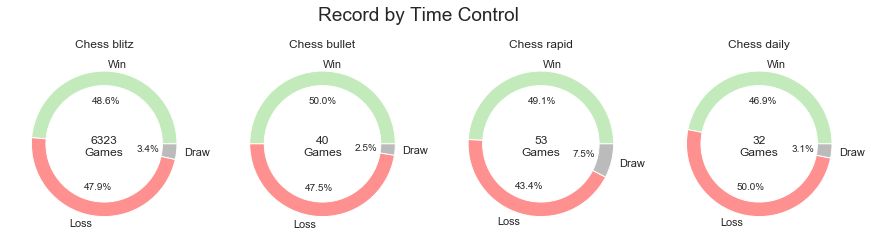

In [142]:
with open('datasets/stats.json', 'r') as f:
    stats = json.load(f)

record = {key: stats[key]['record'] for key in stats if 'record' in stats[key]}
for key in record:
    for value in record[key]:
        record[key] = {k: v for k, v in record[key].items() if k in ('win', 'loss', 'draw')}

colors = {'win': '#c3eabb', 'draw': '#bbbbbb', 'loss': '#ff9090'}
# colors = sns.color_palette('deep', 3)
# colors = [to_rgb(x) for x in  [c_white, c_black, (c_white+c_black)/2]]

def create_record_chart(ax, key):
    data = record[key]
    values = list(data.values())
    labels = list(data.keys())
    ax.pie(values, labels=[x.capitalize() for x in labels], colors=[colors[x] for x in labels], autopct='%.1f%%')
    circle = plt.Circle((0,0), 0.80, fc='white')
    ax.add_artist(circle)
    ax.text(0, -.15, (str(sum(values)) + '\nGames'), ha='center', fontsize=12)
    ax.set_title(' '.join(key.split('_')).capitalize())

fig, axes = plt.subplots(1,4)
fig.set_size_inches((15, 4))
for ax, key in zip(axes.flatten()[::-1], record):  # record and axes are of same length
    create_record_chart(ax, key)
fig.suptitle('Record by Time Control', fontsize=19)
plt.savefig('plots/WinPercentagebyTimeClass.png', dpi=300)

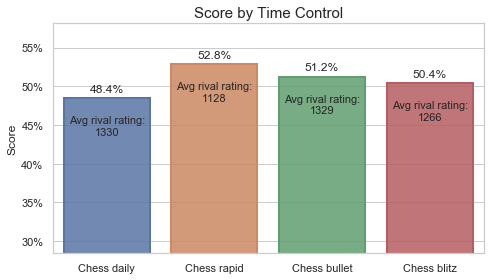

In [320]:
def get_score(d):
    pts = d['win'] + (d['draw'] / 2)
    return pts / sum(d.values())

df = pd.DataFrame(record).T
    

df['score'] = (df.win + (df.draw * .5)) * 100 / df.sum(axis=1)

ax = sns.barplot(df.index, 'score', data=df)
ax.set_xticklabels([' '.join(x.get_text().split('_')).capitalize() for x in ax.get_xticklabels()])
ax.set_ylim(df.score.min() - 20, min(df.score.max() + 10, df.score.max() * 1.1))

for p in ax.patches:
    ax.text(p.get_x() + p.get_width() / 2, p.get_height() + .5, f'{p.get_height():.1f}%', va='bottom', ha='center', fontsize=12)
    p.set_edgecolor(p.get_facecolor())
    p.set_facecolor(p.get_facecolor()[:3] + (0.85,))
    p.set_linewidth(2)
    
ax.set_title('Score by Time Control', fontsize=15)

g = games.groupby('time_class').rival_rating.mean()
g.index = [f'chess_{x}' for x in g.index]

for idx, val in zip(range(10), g):
    ax.text(idx, df.iloc[idx]['score'] - 5,f'Avg rival rating:\n{val:.0f}'.center(17), va='bottom', ha='center', fontsize=11
        )
    

ax.yaxis.set_major_formatter(FormatStrFormatter('%d%%'))

ax.set_ylabel(ax.get_ylabel().capitalize())

ax.figure.set_size_inches(7, 4)

plt.tight_layout()
plt.savefig('plots/ScoreByTimecontrol.png', dpi=300)
plt.show()

# Games
The core of this analysis will be made on this table

This table has loads of data in several levels of depth and I will try to extract the most out of it

In [2]:
games = pd.read_csv('datasets/games.csv', index_col='game_id', parse_dates=True)
games['end_time'] = games.end_time.astype(np.datetime64)

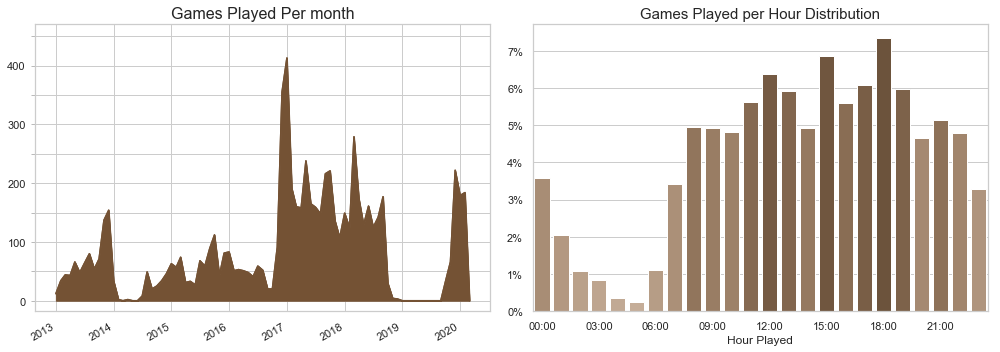

In [10]:
months = games.end_time.apply(lambda x: dt.datetime(year=x.year, month=x.month, day=1))
blitz_games = games.time_class == 'blitz'
monthly_games = games.loc[blitz_games].groupby(months).size().astype(np.int32)

monthly_games = monthly_games.reindex(pd.DatetimeIndex(pd.date_range('2013-01-01', dt.date.today(), freq='MS')))
monthly_games = monthly_games.fillna(0)

pal = browns(len(monthly_games))

fig, ax = plt.subplots(1, 2)

ax, ax1 = ax[0], ax

sns.lineplot(monthly_games.index, monthly_games, color=pal[-1] , ax=ax) # palette=np.array(pal)[ranks]
clr = list(pal[-1])
monthly_games.plot.area(color=to_rgb(*clr), ax=ax)

fig = ax.figure

fig.set_size_inches(8, 4)

# ax.text(idxmax.toordinal(), valmax, str(int(valmax)))
ax.set_ylim(-18, 470)
ax.set_title('Games Played Per month', fontsize=16)
ticks = monthly_games.index
ax.yaxis.set_major_locator(MultipleLocator(100))
ax.yaxis.set_minor_locator(MultipleLocator(50))
ax.tick_params(axis='y', which='minor', color='#bbbbbb', left=True)
ax.grid(True, which='minor', axis='y')
# ax.yaxis.set_minor_formatter(FormatStrFormatter(''))

# ax.set_xticklabels([str(t.year) if t.month == 1 else '' for t in ticks])


ax, ax1 = ax1[1], ax1

g_hours = games.end_time.apply(lambda x: x.hour if x else None)

all_games = games.copy()
play_times = all_games.groupby(g_hours).size()
play_times = play_times.transform(lambda x: x * 100 / x.sum())

ranks = play_times.argsort().argsort()
pal = browns(len(play_times))

sns.barplot(play_times.index, play_times, palette=np.array(pal)[ranks], hue_order=ranks, ax=ax)

ax.set_xticklabels([f'{x:02}:00' if x % 3 == 0 else '' for x in range(24)])

ax.yaxis.set_major_formatter(FormatStrFormatter('%0d%%'))

ax.set_title('Games Played per Hour Distribution', fontsize=15)

ax.set_xlabel('Hour Played')

fig.set_size_inches(14, 5)

plt.tight_layout()
plt.savefig('plots/GamesPerMonth.png', dpi=300)
plt.show()



In [119]:
all_games = games.copy()
f_time = (dt.datetime(2016, 10, 1) < games.end_time) & (games.end_time < dt.datetime(2018, 11, 1))
all_games.loc[f_time, 'end_time'].size

4307

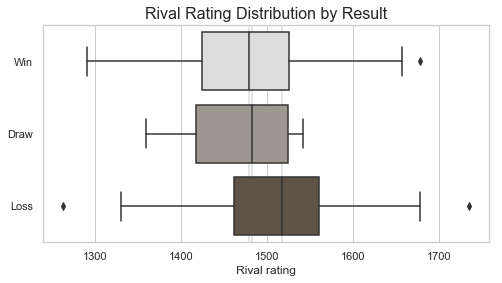

In [130]:
last_year = games.loc[f_last_year].copy()

z_score = last_year.rival_rating.transform(lambda x: (x - x.mean())/x.std())
last_year = last_year.loc[abs(z_score) <= 4]

pal = [to_rgb(x) for x in [c_white, (c_black+c_white)/2, c_black]]

ax = sns.boxplot('rival_rating', 'won', data=last_year, order=['win', 'draw', 'loss'], zorder=1, palette=pal)

for p in ax.patches:
    p.set
rival_rating = last_year.groupby('won')['rival_rating'].median()
for cat in rival_rating:
    ax.axvline(cat, color='#dddddd', zorder=0)
    
ax.set_yticklabels([x.get_text().capitalize() for x in ax.get_yticklabels()])
ax.set_ylabel('')

ax.set_xlabel(' '.join(ax.get_xlabel().split('_')).capitalize())
    
ax.set_title('Rival Rating Distribution by Result', fontsize=16)
ax.figure.set_size_inches(8,4)
    
plt.savefig('plots/RivalDistbyRes.png', dpi=300)

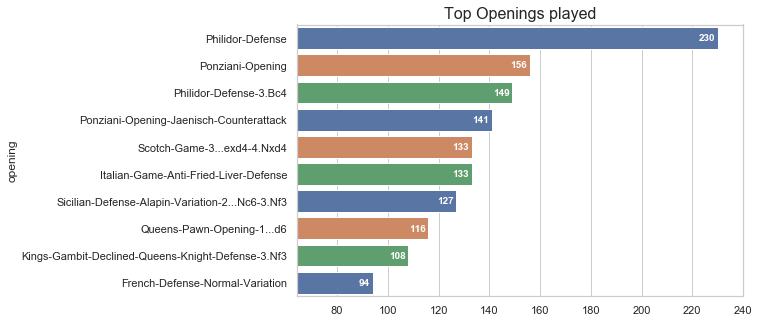

In [53]:
openings = games.groupby('opening')\
            .size()\
            .sort_values(ascending=False)\
            .head(10)

ax = sns.barplot(openings, openings.index, palette=sns.color_palette()[:3])
for p in ax.patches:
    ax.text(p.get_width() - 1,
            p.get_y() + p.get_height()/2,
            int(p.get_width()),
            va='center', ha='right',
            color='white', weight='bold')
    
ax.set_xlim(openings.min() - 30, openings.max() + 10)

ax.set_title('Top Openings played', fontsize=16)

ax.figure.set_size_inches(8, 5)

plt.savefig('plots/TopOpeningsOverall.png', dpi=300)

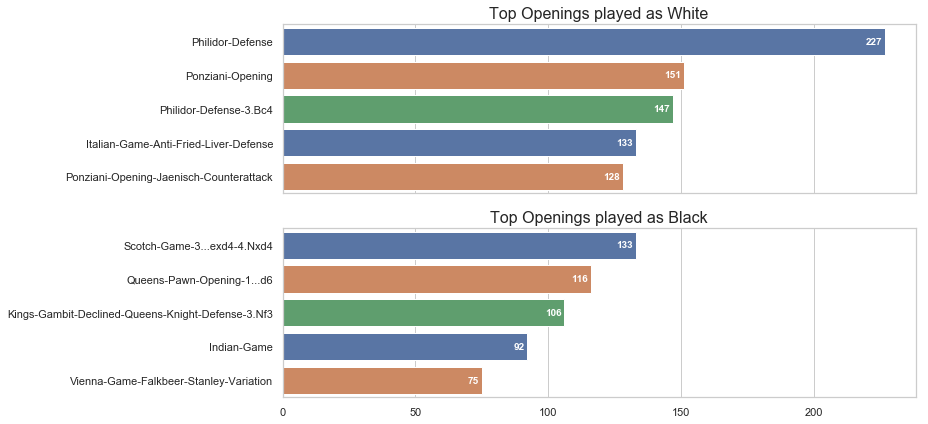

In [347]:
f_1450 = games.rival_rating >= 1450

fig, ax = plt.subplots(2, 1, sharex=True)

def plot_openings(color, ax):
    fil = games.color_played == color
    data = color_openings(fil)
    sns.barplot(data, data.index, ax=ax, palette=sns.color_palette()[:3])
    for p in ax.patches:
        ax.text(p.get_width() - 1,
        p.get_y() + p.get_height()/2,
        int(p.get_width()),
        va='center', ha='right',
        color='white', weight='bold')
        
    xlim = ax.get_xlim()
    lower_bound = max(0, data.min() - 30)
    upper_bound = min(data.max() + 10, data.max()*1.15)
    ax.set_xlim(min(xlim[0], lower_bound), max(xlim[1], upper_bound))
    ax.set_ylabel('')
    ax.set_title(f'Top Openings played as {color}', fontsize=16)
    
    
white_openings = plot_openings('White', ax[0])
black_openings = plot_openings('Black', ax[1])

ax[0].figure.set_size_inches(13, 6)
plt.tight_layout()

plt.savefig('plots/TopOpeningsColors.png', dpi=300)

We can notice my most played opening as white is Philidor Defense, i.e 1.e4 e5 2.Nf3 d6.

Next in line is Ponziani Opening, i.e 1.e4 e6 2.Nf3 Nc6 3. c3, which is my favorite.

Actually, the chess enthusiasts will notice all the Top 5 openings as white I play 1.e4, 2.Nf3, and if possible 3.c3.

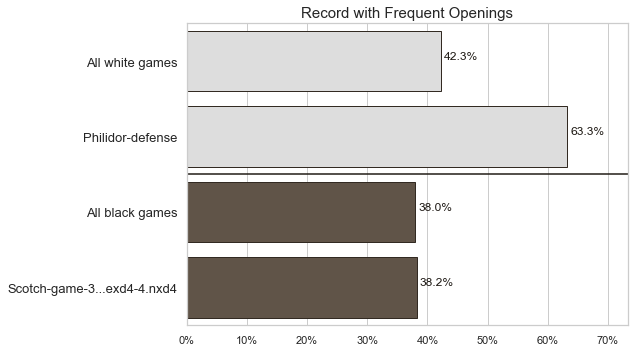

In [348]:
f_1450 = games.rival_rating >= 1450

all_games = games.copy()
all_games['score'] = all_games.won.apply(chess_scores)

freq_white_opening = games.loc[f_white, 'opening'].mode()[0]
f_white_opening = games.opening == freq_white_opening

freq_black_opening = games.loc[f_black, 'opening'].mode()[0]
f_black_opening = games.opening == freq_black_opening

records = []
cuts = {
    'all white games': f_white & f_1450,
    freq_white_opening: f_white_opening & f_white & f_1450,
    'all black games': f_black & f_1450,
    freq_black_opening: f_black_opening & f_black & f_1450
}

for cut in cuts:
    records.append((cut, all_games.loc[cuts[cut]].score.mean()))

records = pd.Series([x[1] for x in records], index=[x[0] for x in records])
records *= 100

pal = [c_white, c_white, c_black, c_black]
pal = [to_rgb(color) for color in pal]
ax = sns.barplot(records, records.index, palette=pal)

for p in ax.patches:
    p.set_edgecolor(to_rgb(c_black*.5))
    ax.text(p.get_width() + .5, p.get_y() + (p.get_height() / 2), f'{p.get_width():.1f}%', va='bottom', ha='left', fontsize=12,
           color = to_rgb(c_black*.3))
    
ax.set_xlim(min(0, records.min() - 20), records.max() + 10)
ax.xaxis.set_major_formatter(FormatStrFormatter('%d%%'))
ax.xaxis.set_major_locator(MultipleLocator(10))

ax.set_yticklabels([x.get_text().capitalize() for x in ax.get_yticklabels()], fontsize=13)

ax.figure.set_size_inches(9, 5)
ax.set_title('Record with Frequent Openings', fontsize=15)

ax.axhline(1.5, color=to_rgb(c_black*.3))
plt.tight_layout()
plt.savefig('plots/RecordWithFrequentOpenings.png', dpi=300)

the philidor Defense is not good enough, as it wins against lower-rated players on average and is not solid enough
let's see what is the best first moves for me to play against the philidor defense.

In [98]:
one_year = dt.timedelta(days=365)
year_ago = dt.datetime.today() - one_year
f_last_year = games.end_time > year_ago

f_philidor = games.moves.apply(philidor_moves).fillna(False)

games['third_move'] = (games['moves']).apply(lambda x: extract_move(x, 3))
third_move_freq = games.loc[f_philidor].groupby('third_move').size().sort_values(ascending=False)

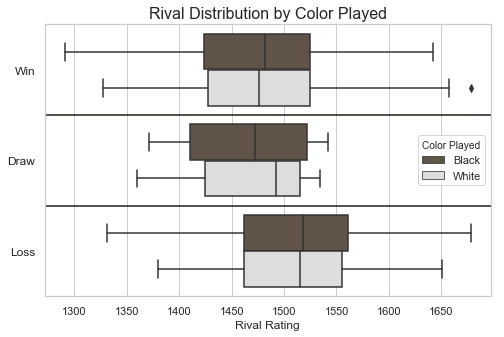

In [340]:
last_year = games.loc[f_last_year].copy()

pal = [c_black, c_white]
pal = [to_rgb(color) for color in pal]

z_score = last_year.groupby(['won', 'color_played'])['rival_rating'].transform(lambda x: (x - x.mean()) / x.std())
last_year = last_year.loc[abs(z_score) <= 3].reset_index()


ax = sns.boxplot(x='rival_rating', y='won', hue='color_played',
            data=last_year, palette=pal,
            order=['win', 'draw', 'loss'])
ax.set_title('Rival Distribution by Color Played', fontsize=16)
ax.figure.set_size_inches(8,5)

ax.set_ylabel('')
ax.legend_.set_title('Color Played')
ax.set_xlabel('Rival Rating')
ax.set_yticklabels([x.get_text().capitalize() for x in ax.get_yticklabels()], fontsize=12)

ax.axhline(0.5, color=to_rgb(c_black*.3))
ax.axhline(1.5, color=to_rgb(c_black*.3))

plt.savefig('plots/RivalDistbyColor.png', dpi=300)


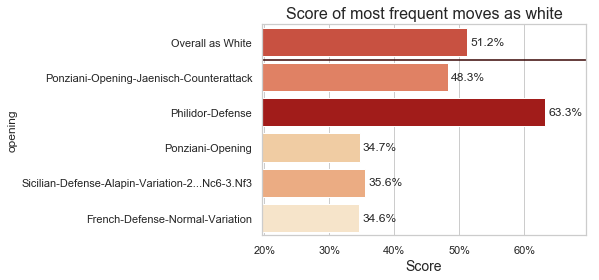

In [497]:
all_games = games.copy()


all_games['score'] = all_games.won.apply(chess_scores)

scores = all_games.loc[f_white & f_1450].groupby('opening').agg({'score': np.mean, 'end_time': np.count_nonzero})

overall_score = (white_openings_df.result * white_openings_df.score).sum() / white_openings_df.result.sum()

data = scores.sort_values('end_time', ascending=False).score.head()
data['Overall as White'] = overall_score
data *= 100

white_pal = np.array(sns.color_palette('OrRd'))

data = data.reindex(['Overall as White'] + data.index[:-1].to_list())

ranks = data.argsort().argsort()

ax = sns.barplot(data, data.index, palette=pal[ranks],)

ax.axhline(.5, color=pal[-1]*.3)

ax.set_xlim(max(0, data.min() - 15), min(data.max() + 10, data.max()*1.1))

for p in ax.patches:
    ax.text(p.get_width() + .5, p.get_height() / 2 + p.get_y(), f'{p.get_width():.1f}%', va='center', fontsize=12)
    
ax.xaxis.set_major_formatter(FormatStrFormatter('%d%%'))
ax.set_xlabel('Score', fontsize=14)

ax.set_title('Score of most frequent moves as white', fontsize=16)

plt.tight_layout()

ax.figure.set_size_inches(13, 4)
plt.savefig('plots/WhiteOpeningsScore.png', dpi=300)

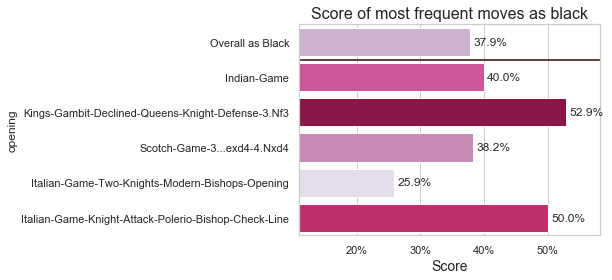

In [499]:

all_games = games.copy()


all_games['score'] = all_games.won.apply(chess_scores)

scores = all_games.loc[f_black & f_1450].groupby('opening').agg({'score': np.mean, 'end_time': np.count_nonzero})

overall_score = (scores.end_time * scores.score).sum() / scores.end_time.sum()

data = scores.sort_values('end_time', ascending=False).score.head()
data['Overall as Black'] = overall_score
data *= 100

black_pal = np.array(sns.color_palette('PuRd'))

data = data.reindex(['Overall as Black'] + data.index[:-1].to_list())

ranks = data.argsort().argsort()

ax = sns.barplot(data, data.index, palette=black_pal[ranks],)

ax.axhline(.5, color=pal[-1]*.3)

ax.set_xlim(max(0, data.min() - 15), min(data.max() + 10, data.max()*1.1))

for p in ax.patches:
    ax.text(p.get_width() + .5, p.get_height() / 2 + p.get_y(), f'{p.get_width():.1f}%', va='center', fontsize=12)
    
ax.xaxis.set_major_formatter(FormatStrFormatter('%d%%'))
ax.set_xlabel('Score', fontsize=14)

ax.set_title('Score of most frequent moves as black', fontsize=16)

plt.tight_layout()
ax.figure.set_size_inches(16, 4)

plt.savefig('plots/BlackOpeningsScore.png', dpi=300)

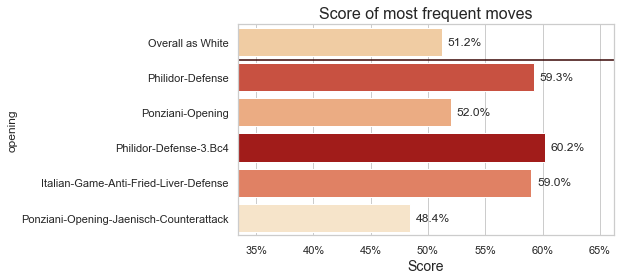

In [469]:
data = scores.sort_values('end_time', ascending=False).score.head()
data['Overall as White'] = overall_score
data *= 100

white_pal = np.array(sns.color_palette('OrRd'))

data = data.reindex(['Overall as White'] + data.index[:-1].to_list())

ranks = data.argsort().argsort()

ax = sns.barplot(data, data.index, palette=pal[ranks],)

ax.axhline(.5, color=pal[-1]*.3)

ax.set_xlim(max(0, data.min() - 15), min(data.max() + 10, data.max()*1.1))

for p in ax.patches:
    ax.text(p.get_width() + .5, p.get_height() / 2 + p.get_y(), f'{p.get_width():.1f}%', va='center', fontsize=12)
    
ax.xaxis.set_major_formatter(FormatStrFormatter('%d%%'))
ax.set_xlabel('Score', fontsize=14)

ax.set_title('Score of most frequent moves', fontsize=16)

plt.tight_layout()
ax.figure.set_size_inches(13, 4)

In [421]:
data = data.reindex(['Overall as White'] + data.index[:-1].to_list())

In [454]:
pal[-1]

array([0.72023068, 0.02435986, 0.01573241])

In [471]:
scores

,score,end_time
opening,,
Alekhines-Defense,1.000000,1
Alekhines-Defense-Scandinavian-Variation-3.e5,0.000000,1
Alekhines-Defense-Scandinavian-Variation-3.exd5,0.333333,3
Alekhines-Defense-Two-Pawns-Attack-3...Nb6,0.000000,4
Caro-Kann-Defense,0.000000,2
...,...,...
Sicilian-Defense-Smith-Morra-Gambit-Accepted,0.000000,2
Sicilian-Defense-Smith-Morra-Morphy-Gambit,1.000000,2
Sicilian-Defense-Taimanov-Variation,0.250000,2


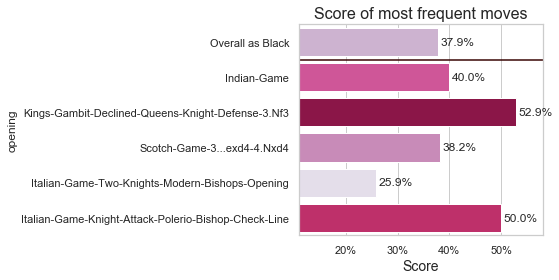

In [476]:
all_games = games.copy()


all_games['score'] = all_games.won.apply(chess_scores)

scores = all_games.loc[f_black & f_1450].groupby('opening').agg({'score': np.mean, 'end_time': np.count_nonzero})

overall_score = (scores.end_time * scores.score).sum() / scores.end_time.sum()

data = scores.sort_values('end_time', ascending=False).score.head()
data['Overall as Black'] = overall_score
data *= 100

black_pal = np.array(sns.color_palette('PuRd'))

data = data.reindex(['Overall as Black'] + data.index[:-1].to_list())

ranks = data.argsort().argsort()

ax = sns.barplot(data, data.index, palette=black_pal[ranks],)

ax.axhline(.5, color=pal[-1]*.3)

ax.set_xlim(max(0, data.min() - 15), min(data.max() + 10, data.max()*1.1))

for p in ax.patches:
    ax.text(p.get_width() + .5, p.get_height() / 2 + p.get_y(), f'{p.get_width():.1f}%', va='center', fontsize=12)
    
ax.xaxis.set_major_formatter(FormatStrFormatter('%d%%'))
ax.set_xlabel('Score', fontsize=14)

ax.set_title('Score of most frequent moves', fontsize=16)

plt.tight_layout()
ax.figure.set_size_inches(13, 4)

In [473]:
scores

,score,end_time
opening,,
Birds-Opening,0.000000,2
Birds-Opening-1...Nf6,1.000000,1
Birds-Opening-1...Nf6-2.Nf3,0.000000,1
Birds-Opening-1...Nf6-2.Nf3-g6,1.000000,1
Birds-Opening-Dutch-Variation-2.Nf3,0.583333,6
...,...,...
Vienna-Game-Falkbeer-Stanley-Variation,0.208333,12
Vienna-Game-Falkbeer-Stanley-Variation-3...Bc5,1.000000,1
Vienna-Game-Falkbeer-Variation,0.500000,2


In [501]:
all_games = games.copy()

all_games['move_list'] = all_games.moves.apply(lambda x: re.findall

game_id
58796722      1. Nf3 d5 2. d4 Nc6 3. b3 Bf5 4. Nc3 Nf6 5. Bg...
58954390      1. d4 d5 2. Bf4 Nc6 3. Nc3 Nf6 4. e3 Bg4 5. Be...
59733972      1. d4 d5 2. c4 dxc4 3. e3 Nf6 4. Bxc4 e6 5. Nc...
59812634      1. d4 Nf6 2. f3 d5 3. Nc3 Bf5 4. g4 Bg6 5. Bg5...
59937432      1. d4 d5 2. c4 e6 3. Nd2 Nc6 4. e4 Nf6 5. f3 B...
                                    ...                        
4523920681    1. e4 d6 2. d4 c6 3. c4 Qc7 4. Bf4 e5 5. Bg3 N...
4524369234    1. e4 c5 2. Nf3 Nc6 3. c3 d6 4. h3 e5 5. d4 cx...
4524896919    1. e4 d5 2. exd5 Nf6 3. Nf3 Nxd5 4. Bc4 e6 5. ...
4524923604    1. e4 e5 2. Nf3 Nf6 3. Nc3 d6 4. h3 h6 5. d3 B...
4524950049    1. e4 e5 2. Nf3 Nc6 3. Bc4 Nf6 4. Ng5 d5 5. ex...
Name: moves, Length: 7601, dtype: object

In [518]:
s = all_games.iloc[0]['moves']
def get_movelist(s):
    li = re.findall(r'[0-9]\. ([\w\+#]* [\w\+#]*)', s)
    li = [tuple(x.split()) for x in li]
    return li
    
all_games.loc[all_games.moves.notna(), 'move_list'] = all_games.loc[all_games.moves.notna(), 'moves'].apply(get_movelist)

In [531]:
thirdmove = all_games.loc[f_philidor, 'moves'].apply(lambda x: extract_move(x, 3))

In [633]:
thirdmove_df = all_games.loc[f_philidor].groupby(thirdmove).agg({'score': [np.mean, np.size], 'rival_rating': np.mean})
thirdmove_df[('score', 'mean')] *= 100

In [634]:
thirdmove_df.columns = ['score_mean', 'score_size', 'rival_mean']

Text(0, 0.5, 'Rival Average')

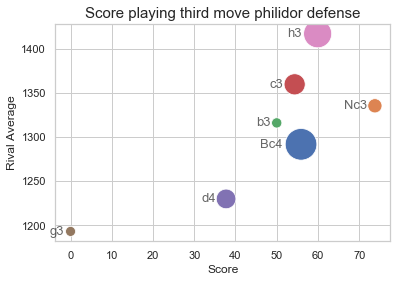

In [651]:
ax = sns.scatterplot(thirdmove_df.score_mean, thirdmove_df.rival_mean, size=thirdmove_df.score_size, hue=thirdmove_df.index, legend=False, sizes=(100, 1000))

for idx, row in thirdmove_df.iterrows():
    ax.text(row['score_mean'] - 1.5 - row.score_size / (thirdmove_df.score_size.max() / 3), row['rival_mean'], str(idx), ha='right', va='center', fontsize=13, alpha=.7)
    
ax.set_title('Score playing third move philidor defense', fontsize=15)

ax.set_xlabel('Score')
ax.set_ylabel('Rival Average')